### **Business and Data Understanding**

For this project, we utilized a dataset consisting of approximately 9,000 tweet sentiments about Apple and Google products. The dataset includes columns such as tweet_text, emotion_in_tweet_is_directed_at, and is_there_an_emotion_directed_at_a_brand_or_product. The objective was to develop a sentiment analysis model that could accurately classify tweets into positive, negative, or neutral sentiment categories.


### **Data Preparation**

To prepare the data, we performed various preprocessing steps. These included removing duplicates, handling missing values by filling them with "none" for the emotion_in_tweet_is_directed_at column, and dropping the row with a missing tweet_text. We also employed tokenization, lowercase conversion, stopword removal, and lemmatization to refine the text data.


### **Modeling**

The packages/libraries utilized for data preparation and analysis included NLTK, sklearn, and pandas. NLTK was used for tokenization, stopword removal, and lemmatization. Sklearn's CountVectorizer and Tf-IdfVectorizer were employed for vectorization. Pandas was used for data manipulation and handling missing values.
For modeling, we employed logistic regression as the binary classifier to classify tweets into positive or negative sentiment categories. As a benchmark, we aimed for an accuracy of 85%. In addition, we expanded the model to a multiclass classifier to include the neutral sentiment category.


### **Evaluation**

To evaluate the performance of the final model, we employed accuracy, precision, and recall metrics. These metrics provided insights into the model's ability to correctly classify instances and predict positive, negative, and neutral sentiments.

In conclusion, the sentiment analysis model developed using logistic regression demonstrated satisfactory performance in classifying tweet sentiments. The pre-processing steps and modeling choices contributed to accurate predictions and meaningful insights. However, limitations such as missing values and data quality issues should be considered when interpreting the results. Recommendations include further refining the model and expanding the dataset for improved sentiment analysis accuracy.


### Data understanding

We will start by importing all libraries used throughout the notebook.

In [1]:
#loading libraries

import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import FreqDist

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# loading and previewing data

data = pd.read_csv('data.csv', encoding='ISO-8859-1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Describing the dataset

In [3]:
# class to describe dataset

class Describer:
    
    # initialize object
    def __init__(self, df):
        self.df = df
        
    # method to check shape of data
    def shape(self):
        out = print(f"The DataFrame has:\n\t* {self.df.shape[0]} rows\n\t* {self.df.shape[1]} columns", '\n')
        return out
    
    # method to check info on dataset
    def data_info(self):
        out = print(self.df.info(), '\n')
        return out
    
    # method to describe numerical columns
    def data_describe(self):
        out = self.df.describe()
        return out

In [4]:
# creating an instance of the class describer
describe_df = Describer(data)

# lets view the shape of the data
describe_df.shape()

The DataFrame has:
	* 9093 rows
	* 3 columns 



In [5]:
# lets print summary infomation on the dataset
print('Summary infomation on dataset')
print('-----------------------------------------------')
describe_df.data_info()

Summary infomation on dataset
-----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None 



### summary of data understanding

The dataset has 3 columns  namely:tweet_text, emotion_in_tweet_is_directed_at ,is_there_an_emotion_directed_at_a_brand_or_product

The  dataset has 9093 rows

All the  dataset's columns  datatypes are objects

## 3. Data Preparation 

#### Introduction
we will be preparing our data for analysis by checking for attributes such as missing values ,duplicates and other inconsistencies as computed below

### missing values

In [6]:
# function to identify missing values

# identify missing 
def identify_missing_values(data):
    """Identify is the data has missing values"""
    # identify if data has missing values(data.isnull().any())
    # empty dict to store missing values
    missing = []
    for i in data.isnull().any():
        # add the bool values to empty list 
        missing.append(i)
    # covert list to set (if data has missing value, the list should have true and false)
    missing_set = set(missing)
    if (len(missing_set) == 1):
        out = print("The Data has no missing values")
    else:
        out = print("The Data has missing values.")

    return out

identify_missing_values(data)

The Data has missing values.


In [7]:
# function to display missing values

def missing_values(data):
    """A simple function to identify data has missing values"""
    # identify the total missing values per column
    # sort in order 
    miss = data.isnull().sum().sort_values(ascending = False)

    # calculate percentage of the missing values
    percentage_miss = (data.isnull().sum() / len(data)).sort_values(ascending = False)

    # store in a dataframe 
    missing = pd.DataFrame({"Missing Values": miss, "Percentage(%)": percentage_miss})

    # remove values that are missing 
    missing.drop(missing[missing["Percentage(%)"] == 0].index, inplace = True)

    return missing


missing_values(data)


,Missing Values,Percentage(%)
emotion_in_tweet_is_directed_at,5802,0.638073
tweet_text,1,0.000110


In [8]:
# dropping missing row in tweet_text

data.dropna(axis=0,subset=['tweet_text'],inplace=True)

In [9]:
# confirmation

data.isna().any()

tweet_text                                            False
emotion_in_tweet_is_directed_at                        True
is_there_an_emotion_directed_at_a_brand_or_product    False
dtype: bool

In [10]:
# replacing null values in recipient with nan

data['emotion_in_tweet_is_directed_at'].fillna('none', inplace =True)

In [11]:
data['emotion_in_tweet_is_directed_at'].value_counts()

none                               5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [12]:
data.isna().any()

tweet_text                                            False
emotion_in_tweet_is_directed_at                       False
is_there_an_emotion_directed_at_a_brand_or_product    False
dtype: bool

####  justification

We discovered that there is ```0.01%``` missing values in tweet_text column and  ```63.81%``` missing values in emotion_in_tweet_is_directed_at column

We replaced the missing values in the ```emotion tweet is directed at column``` with none for computational purposes and dropped the missing valuesin the ```tweet text```   column

### Duplicates

In [13]:
# checking for duplicates

# Duplicated entries
def identify_duplicates(data):
    """Simple function to identify any duplicates"""
    # identify the duplicates (dataframename.duplicated() , can add .sum() to get total count)
    # empty list to store Bool results from duplicated
    duplicates = []
    for i in data.duplicated():
        duplicates.append(i)
    # identify if there is any duplicates. (If there is any we expect a True value in the list duplicates)
    duplicates_set = set(duplicates) 
    if (len(duplicates_set) == 1):
        print("The Data has no duplicates")
    else:
        no_true = 0
        for val in duplicates:
            if (val == True):
                no_true += 1
        # percentage of the data represented by duplicates 
        duplicates_percentage = np.round(((no_true / len(data)) * 100), 3)
        print(f"The Data has {no_true} duplicated rows.\nThis constitutes {duplicates_percentage}% of the data set.") 



identify_duplicates(data)

The Data has 22 duplicated rows.
This constitutes 0.242% of the data set.


In [14]:
data.duplicated().sum()

22

In [15]:
# handling the duplicates 
def remove_duplicated_rows(data):
    """Simple Function to remove duplicated rows"""
    data.drop_duplicates(subset=None, keep="first", inplace=True)
    # confirm if the duplicated rows have been removed
    confirm = identify_duplicates(data)

    return confirm 


remove_duplicated_rows(data)

The Data has no duplicates


#### summary
We found out that the tweet text column had 22 duplicates ```( 0.242% )``` and went ahead and  dropped  them.

In [16]:
# renaming the columns
data = data.rename(columns={'emotion_in_tweet_is_directed_at':'recipient',
                    'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'})
data.head()

,tweet_text,recipient,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


```Insight```
We renamed  the column ```emotion_in_tweet_is_directed_at``` to ```recipient``` and the column ```is_there_an_emotion_directed_at_a_brand_or_product``` to ```emotion``` to enhance clarity and facilitate their usage in our subsequent computation


## 4. EDA

#### Introduction

We  will conduct Univariate and Bivariate analysis of the sentiments and create visualizations  to see how they relate with each other and individually.


### Univariate analysis


No emotion toward brand or product    59.261301
Positive emotion                      32.745314
Negative emotion                       6.273429
I can't tell                           1.719956
Name: emotion, dtype: float64


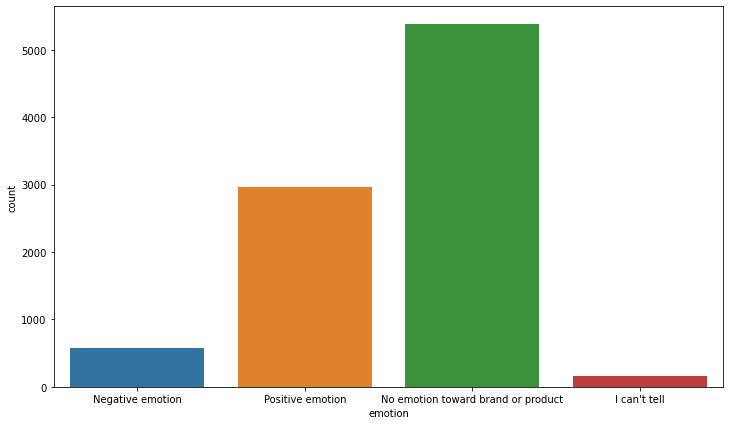

In [18]:
# checking the distribution of emotions

percentage = data['emotion'].value_counts(normalize=True)
print(percentage * 100)

# count plot
plt.figure(figsize=(12, 7))
sns.countplot(data['emotion']);

# Observation

We see that majority of  people had  ```No emotion toward brand or product``` at ```59.26%``` followed by people with ```Positive emotions ``` at ```32.75%```

```I can't tell``` makes up less than ```2%``` of our dataset, and doesn't offer much more information in the way of word significance than the tweets labeled No emotion toward brand or product. We will drop records where emotion has been recorded as ```I can't tell```.

### Bivariate analysis

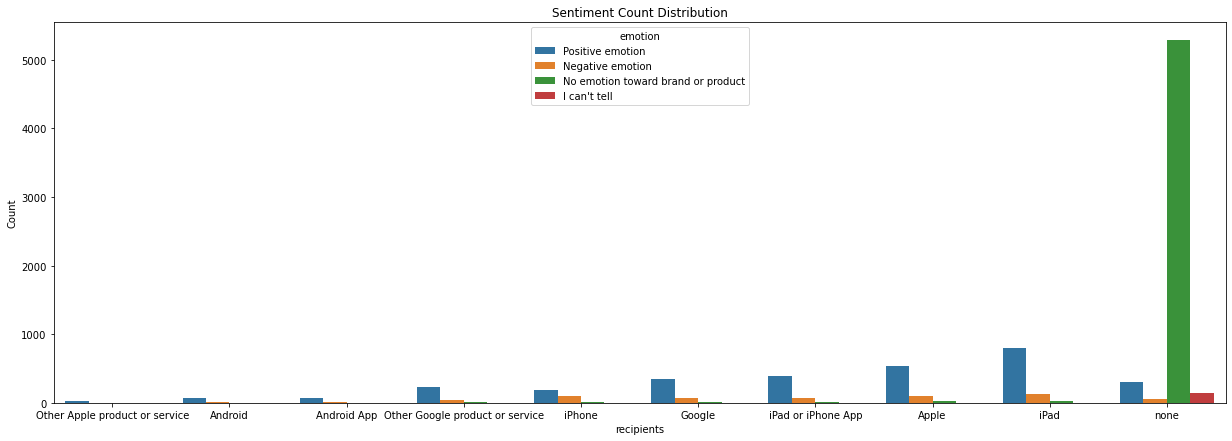

In [19]:
# lets see see sentiment distribution product-wise
recipient_group = data.groupby('recipient')['emotion'].value_counts().reset_index(name='count')
# Calculate the ascending order of states based on churn count
ascending_order = recipient_group.groupby('recipient')['count'].sum().sort_values().index

plt.figure(figsize=(21,7))
sns.barplot(x='recipient', y='count', hue='emotion', data=recipient_group, order=ascending_order)
plt.xlabel('recipients')
plt.ylabel('Count')
plt.title('Sentiment Count Distribution')
plt.show()

# Interpretation

From the graph above  ```Ipad```  had the ```highest positive emotions``` followed by ```Apple```

In [20]:
data['recipient'].value_counts()

none                               5788
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: recipient, dtype: int64

In [21]:
# overall brand distribution

# feature engineering
data['brand'] = data['recipient'].map({'Other Apple product or service': 'Apple', 
                                           'Android': 'Google',
                                           'Android App': 'Google',
                                           'Other Google product or service ': 'Google',
                                           'iPhone': 'Apple', 
                                           'Google':'Google',
                                           'iPad or iPhone App': 'Apple',
                                           'Apple':'Apple',
                                           'iPad':'Apple',
                                           'none': 'none'})



In [22]:
data.head(3)

,tweet_text,recipient,emotion,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple


none      65.945084
Apple     27.389769
Google     6.665148
Name: brand, dtype: float64


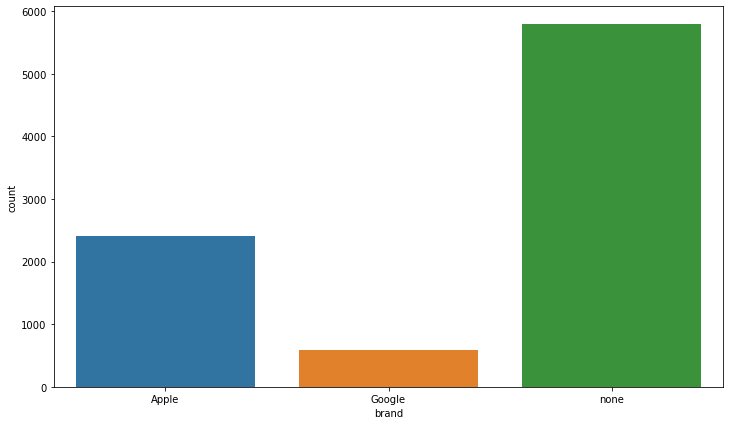

In [23]:
# checking the distribution of brand sentiment

percentage = data['brand'].value_counts(normalize=True)
print(percentage * 100)

# count plot
plt.figure(figsize=(12, 7))
sns.countplot(data['brand']);

#### ***Insight***

From the graph above Majority of people had not specified the brand, and for those who did, ```Apple``` had the highest sentiment feedback as compared to ```Google```

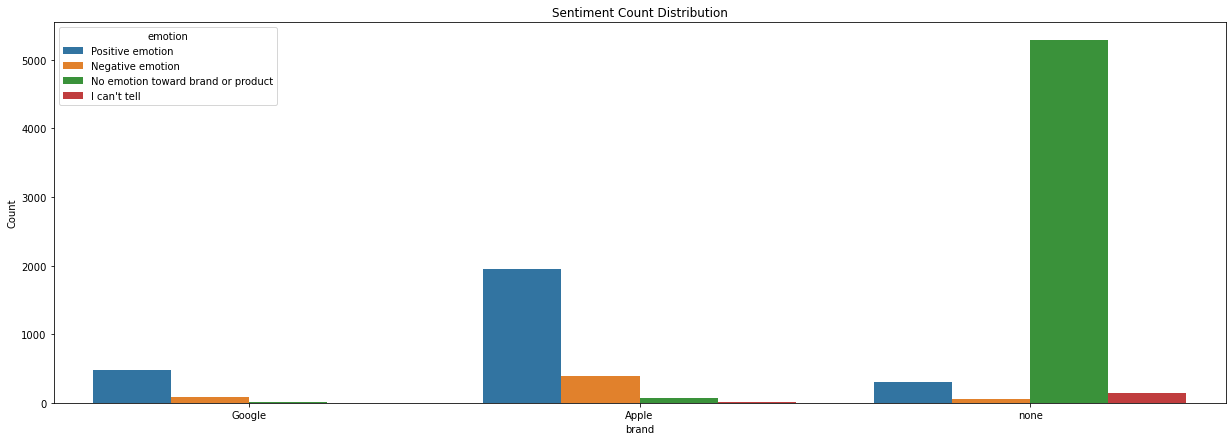

In [24]:
# lets see see sentiment distribution brand-wise
brand_group = data.groupby('brand')['emotion'].value_counts().reset_index(name='count')
# Calculate the ascending order of states based on churn count
ascending_order = brand_group.groupby('brand')['count'].sum().sort_values().index

plt.figure(figsize=(21,7))
sns.barplot(x='brand', y='count', hue='emotion', data=brand_group, order=ascending_order)
plt.xlabel('brand')
plt.ylabel('Count')
plt.title('Sentiment Count Distribution')
plt.show()

#### ***Intepretation***

From the graph above ```Apple``` had the highest ```positive emotions``` compared to ```Google```

## 5. Preprocessing

### *** Introduction***

In this section we will make the tweets lower case, remove html tags ,remove the Url , expand the contradictions ,remove the punctuations ,tokenize ,remove stopwords and lemmatize the tweet

In [25]:
data.columns

Index(['tweet_text', 'recipient', 'emotion', 'brand'], dtype='object')

In [26]:
# normalizing the data to lowecase
data['tweet_text'] = data['tweet_text'].str.lower()
data.head(2)

,tweet_text,recipient,emotion,brand
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,Apple


In [27]:
data['tweet_text'][14]

'great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l'

In [28]:
# removing the html tags
def remove_html(review):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', review)

data['tweet_text'] = data['tweet_text'].apply(remove_html)

In [29]:
# removing URL and @ sign

def preprocess_text_removingq_URLand_atsign(text):
    # Remove URLs
    clean_text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r'@[^\s]+', 'user', clean_text)
    # Other preprocessing steps like removing punctuation, converting to lowercase, etc.
    # ...
    return text

data['tweet_text'] = data['tweet_text'].apply(preprocess_text_removingq_URLand_atsign)

In [30]:
data['tweet_text'][14]

'great #sxsw ipad app from user '

In [31]:
data.head()

,tweet_text,recipient,emotion,brand
0,.user i have a 3g iphone. after 3 hrs tweeting...,iPhone,Negative emotion,Apple
1,user know about user ? awesome ipad/iphone app...,iPad or iPhone App,Positive emotion,Apple
2,user can not wait for #ipad 2 also. they shoul...,iPad,Positive emotion,Apple
3,user i hope this year's festival isn't as cras...,iPad or iPhone App,Negative emotion,Apple
4,user great stuff on fri #sxsw: marissa mayer (...,Google,Positive emotion,Google


In [32]:
# function to remove hash, not alphabet 

In [33]:
# expanding the contractions (is-nots)

import contractions
#from nltk.stem import WordNetLemmatizer

def expand(text):
    # Expand contractions
    expanded_text = contractions.fix(text)

    return expanded_text

data['tweet_text'] = data['tweet_text'].apply(expand)

In [34]:
data.tweet_text[3]

"user i hope this year's festival is not as crashy as this year's iphone app. #sxsw"

In [35]:
# punctuation
exclude = string.punctuation
print(exclude)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [36]:
# remove punctuations
def remove_punctuations(tweet):
    return tweet.translate(str.maketrans('','',exclude))

In [37]:
data['tweet_text']=data['tweet_text'].apply(remove_punctuations)
data.head()

,tweet_text,recipient,emotion,brand
0,user i have a 3g iphone after 3 hrs tweeting a...,iPhone,Negative emotion,Apple
1,user know about user awesome ipadiphone app t...,iPad or iPhone App,Positive emotion,Apple
2,user can not wait for ipad 2 also they should ...,iPad,Positive emotion,Apple
3,user i hope this years festival is not as cras...,iPad or iPhone App,Negative emotion,Apple
4,user great stuff on fri sxsw marissa mayer goo...,Google,Positive emotion,Google


In [38]:
data.tweet_text[20]

'need to buy an ipad2 while i am in austin at sxsw not sure if i will need to q up at an austin apple store'

#### Tokenization

In [39]:
# tokenize the tweets
def tokenize_text(tweet):
    return word_tokenize(tweet)

data['tweet_text'] = data['tweet_text'].apply(tokenize_text)
data.head()

,tweet_text,recipient,emotion,brand
0,"[user, i, have, a, 3g, iphone, after, 3, hrs, ...",iPhone,Negative emotion,Apple
1,"[user, know, about, user, awesome, ipadiphone,...",iPad or iPhone App,Positive emotion,Apple
2,"[user, can, not, wait, for, ipad, 2, also, the...",iPad,Positive emotion,Apple
3,"[user, i, hope, this, years, festival, is, not...",iPad or iPhone App,Negative emotion,Apple
4,"[user, great, stuff, on, fri, sxsw, marissa, m...",Google,Positive emotion,Google


In [40]:
# removing stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(tweet):
    # Use list comprehension for efficient list creation
    new_tweet = [word for word in tweet if word not in stop_words]
    return " ".join(new_tweet)

# Apply the function to the 'review' column
data['tweet_text'] = data['tweet_text'].apply(remove_stopwords)
data.head()

,tweet_text,recipient,emotion,brand
0,user 3g iphone 3 hrs tweeting riseaustin dead ...,iPhone,Negative emotion,Apple
1,user know user awesome ipadiphone app likely a...,iPad or iPhone App,Positive emotion,Apple
2,user wait ipad 2 also sale sxsw,iPad,Positive emotion,Apple
3,user hope years festival crashy years iphone a...,iPad or iPhone App,Negative emotion,Apple
4,user great stuff fri sxsw marissa mayer google...,Google,Positive emotion,Google


In [41]:
data.emotion.value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: emotion, dtype: int64

#### Words Distribution in Tweet Text

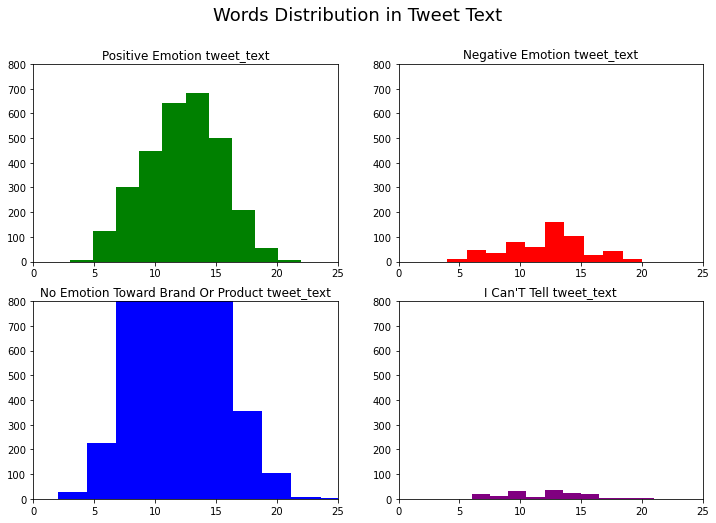

In [42]:
def generate_review_hist_plot(data, label, color, ax):
    tweet_len = data[data['emotion']==label].tweet_text.str.split().map(lambda x: len(x))
    ax.set_xlim(0, 25)
    ax.set_ylim(0, 800)
    ax.hist(tweet_len, color=color)
    ax.set_title(f'{label.title()} tweet_text')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
generate_review_hist_plot(data,'Positive emotion','green',ax[0,0])
generate_review_hist_plot(data,'Negative emotion','red',ax[0,1])
generate_review_hist_plot(data,'No emotion toward brand or product','blue',ax[1,0])
generate_review_hist_plot(data,"I can't tell",'purple',ax[1,1])

fig.suptitle("Words Distribution in Tweet Text", fontsize=18)

plt.show()

In [43]:
# re-tokenizing the data

data['tweet_text'] = data['tweet_text'].apply(tokenize_text)
data.head()

,tweet_text,recipient,emotion,brand
0,"[user, 3g, iphone, 3, hrs, tweeting, riseausti...",iPhone,Negative emotion,Apple
1,"[user, know, user, awesome, ipadiphone, app, l...",iPad or iPhone App,Positive emotion,Apple
2,"[user, wait, ipad, 2, also, sale, sxsw]",iPad,Positive emotion,Apple
3,"[user, hope, years, festival, crashy, years, i...",iPad or iPhone App,Negative emotion,Apple
4,"[user, great, stuff, fri, sxsw, marissa, mayer...",Google,Positive emotion,Google


In [44]:
data.tweet_text[0]

['user',
 '3g',
 'iphone',
 '3',
 'hrs',
 'tweeting',
 'riseaustin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw']

# justifications of retokenizing

We retokinized since after removing the stopwords the tweets were  nolonger split as strings.

### frequency distribution after removing stopwords

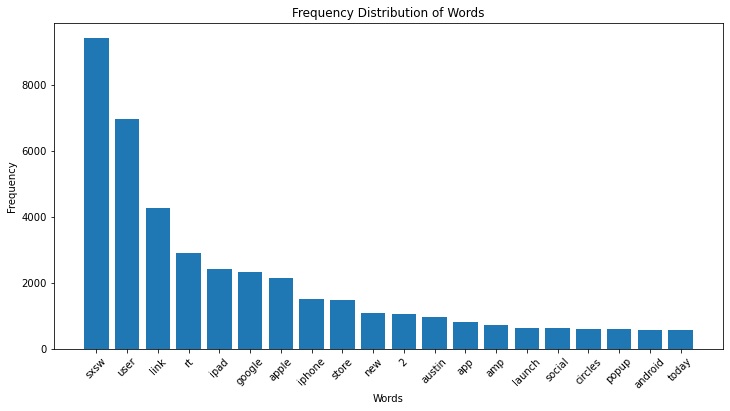

In [45]:
tweet_texts = data.tweet_text
# Flatten the list of tokens into a single list
all_tokens = [tweet for sublist in tweet_texts for tweet in sublist]

# Create the frequency distribution
freq_dist = FreqDist(all_tokens)

# Get the most common words
most_common = freq_dist.most_common(20)  # Example: Top 20 most common words

# Extract the words and frequencies
words, frequencies = zip(*most_common)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Words')
plt.xticks(rotation=45)
plt.show()

#### ***justification***
Just by looking at this, we can see there is a high occurence of

* venue specific words such as ```sxsw```

* twitter specific words such as ```rt```

* brand or product specific words such as ```iphone```

These words probably occur across our various sentiments and may not necessarily add any meaning, unless a majority of their occurence is associated with a particular emotion


In [46]:
# lemmatization

# Create Lemmatizer and Stemmer.
word_lem = WordNetLemmatizer()

# function
def lem_words(tweet):
    return [word_lem.lemmatize(word) for word in tweet]

In [47]:
data['tweet_text'] = data['tweet_text'].apply(lem_words)
data['tweet_text'].head()

0    [user, 3g, iphone, 3, hr, tweeting, riseaustin...
1    [user, know, user, awesome, ipadiphone, app, l...
2              [user, wait, ipad, 2, also, sale, sxsw]
3    [user, hope, year, festival, crashy, year, iph...
4    [user, great, stuff, fri, sxsw, marissa, mayer...
Name: tweet_text, dtype: object

In [48]:
data.head()

,tweet_text,recipient,emotion,brand
0,"[user, 3g, iphone, 3, hr, tweeting, riseaustin...",iPhone,Negative emotion,Apple
1,"[user, know, user, awesome, ipadiphone, app, l...",iPad or iPhone App,Positive emotion,Apple
2,"[user, wait, ipad, 2, also, sale, sxsw]",iPad,Positive emotion,Apple
3,"[user, hope, year, festival, crashy, year, iph...",iPad or iPhone App,Negative emotion,Apple
4,"[user, great, stuff, fri, sxsw, marissa, mayer...",Google,Positive emotion,Google


#### dealing with emojis

We create a function that replaces emojis in tweet text with their corresponding meanings.

In [49]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [50]:
def process(tweets):
    
    processed_tweet = []
    
    
    # Defining regex patterns.
    
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in tweets:
        
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])              
            # Replace 3 or more consecutive letters by 2 letter.
            tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        processed_tweet.append(tweet)
        
    return processed_tweet

In [51]:
data['tweet_text'] = data['tweet_text'].apply(process)
data.head()

,tweet_text,recipient,emotion,brand
0,"[user, 3g, iphone, 3, hr, tweeting, riseaustin...",iPhone,Negative emotion,Apple
1,"[user, know, user, awesome, ipadiphone, app, l...",iPad or iPhone App,Positive emotion,Apple
2,"[user, wait, ipad, 2, also, sale, sxsw]",iPad,Positive emotion,Apple
3,"[user, hope, year, festival, crashy, year, iph...",iPad or iPhone App,Negative emotion,Apple
4,"[user, great, stuff, fri, sxsw, marissa, mayer...",Google,Positive emotion,Google


In [52]:
data.tweet_text[0]

['user',
 '3g',
 'iphone',
 '3',
 'hr',
 'tweeting',
 'riseaustin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station',
 'sxsw']

# vectorization

In [53]:
# create instance 1 vectorizer
bow = CountVectorizer()
data['lemmatized_review'] = data['tweet_text'].str.join(" ")
x = bow.fit_transform(data['lemmatized_review'])

In [108]:
feature_name = bow.get_feature_names_out()
feature_name

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names_out'

In [ ]:
# write observation of code above


### label encoding the target

Here we label encode the target feature to transform the values to numerical values.

In [55]:
# import library
from sklearn.preprocessing import LabelEncoder

In [56]:
le = LabelEncoder() # initializing the lib
data['emotion_code'] = le.fit_transform(data.emotion)
le.classes_ # viewing the classes

array(["I can't tell", 'Negative emotion',
       'No emotion toward brand or product', 'Positive emotion'],
      dtype=object)

#### Previewing to ensure encoding is present

In [57]:
# preview
data.head()

,tweet_text,recipient,emotion,brand,lemmatized_review,emotion_code
0,"[user, 3g, iphone, 3, hr, tweeting, riseaustin...",iPhone,Negative emotion,Apple,user 3g iphone 3 hr tweeting riseaustin dead n...,1
1,"[user, know, user, awesome, ipadiphone, app, l...",iPad or iPhone App,Positive emotion,Apple,user know user awesome ipadiphone app likely a...,3
2,"[user, wait, ipad, 2, also, sale, sxsw]",iPad,Positive emotion,Apple,user wait ipad 2 also sale sxsw,3
3,"[user, hope, year, festival, crashy, year, iph...",iPad or iPhone App,Negative emotion,Apple,user hope year festival crashy year iphone app...,1
4,"[user, great, stuff, fri, sxsw, marissa, mayer...",Google,Positive emotion,Google,user great stuff fri sxsw marissa mayer google...,3


In [58]:
# displaying the encoding scheme
data[['emotion', 'emotion_code']].head(10)

,emotion,emotion_code
0,Negative emotion,1
1,Positive emotion,3
2,Positive emotion,3
3,Negative emotion,1
4,Positive emotion,3
5,No emotion toward brand or product,2
7,Positive emotion,3
8,Positive emotion,3
9,Positive emotion,3
10,Positive emotion,3


# 6. Modelling
* The problem at hand is a classification problem.
* We will explore 3 models: a binary logisticregression model, a multi-class XGBoost model and a tuned random forest model.
* Model accuracy will be the metrics for evaluation.
* Justification: Accuracy to get a verdict if a tweet is positive or negative.

* Accuracy of 70% will be the threshold to deam the model as successful.

### 6.1 Binary classification
* In this section we create a base model to identify if a tweet is 'Positive' or 'Negative'.
* LogisticRegression will be used for the classification.
* The normal preprocessing of vectorization and train test split will be implemented.

In [59]:
# creating a copy of the original data so as to remove unwanted rows i.e. (not positive or negative)
data_copy = data.copy()

In [60]:
# Define the values to drop
values_to_drop = [0, 2]

# Drop rows that have the values in column 'B'
data_copy = data_copy[~data_copy['emotion_code'].isin(values_to_drop)]

In [61]:
# value counts
data_copy['emotion_code'].value_counts()

3    2970
1     569
Name: emotion_code, dtype: int64

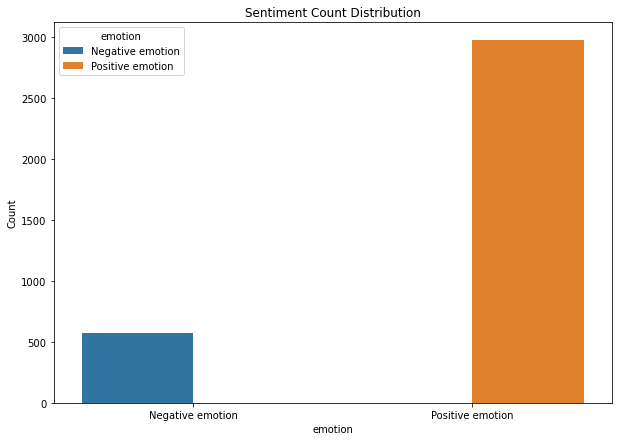

In [62]:
# lets see see binary sentiment distribution emotion-wise
emotion_group = data_copy.groupby('emotion')['emotion_code'].value_counts().reset_index(name='count')
# Calculate the ascending order of states based on churn count
ascending_order = emotion_group.groupby('emotion')['count'].sum().sort_values().index

plt.figure(figsize=(10,7))
sns.barplot(x='emotion', y='count', hue='emotion', data=emotion_group, order=ascending_order)
plt.xlabel('emotion')
plt.ylabel('Count')
plt.title('Sentiment Count Distribution')
plt.show()

### intepretation

* From the graph above it is clear that most of the sentiments were positive in nature


### vectorizing data copy

In [63]:
# create instance of vectorizer
bow2 = CountVectorizer()
data_copy['lemmatized_review'] = data_copy['tweet_text'].str.join(" ")
x2 = bow2.fit_transform(data_copy['lemmatized_review'])

In [64]:
# preview
data_copy.head()

,tweet_text,recipient,emotion,brand,lemmatized_review,emotion_code
0,"[user, 3g, iphone, 3, hr, tweeting, riseaustin...",iPhone,Negative emotion,Apple,user 3g iphone 3 hr tweeting riseaustin dead n...,1
1,"[user, know, user, awesome, ipadiphone, app, l...",iPad or iPhone App,Positive emotion,Apple,user know user awesome ipadiphone app likely a...,3
2,"[user, wait, ipad, 2, also, sale, sxsw]",iPad,Positive emotion,Apple,user wait ipad 2 also sale sxsw,3
3,"[user, hope, year, festival, crashy, year, iph...",iPad or iPhone App,Negative emotion,Apple,user hope year festival crashy year iphone app...,1
4,"[user, great, stuff, fri, sxsw, marissa, mayer...",Google,Positive emotion,Google,user great stuff fri sxsw marissa mayer google...,3


### Train-test split

In [65]:
# modelling libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics

In [66]:
#x = bow.fit_transform(data['lemmatized_review'])
y = data_copy['emotion_code']

In [67]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size=0.2, random_state=42)

In [68]:
# confirming shape

X_train.shape, y_train.shape

((2831, 5871), (2831,))


### Fitting logistic regression model on split data

In [69]:
# instantiating model 1
log_reg = LogisticRegression(random_state=42)

In [70]:
# fitting
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [71]:
# predicting
y_pred = log_reg.predict(X_test)
y_train_pred = log_reg.predict(X_train)

### evaluation

In [72]:
print('train',accuracy_score(y_train, y_train_pred))
print('test',accuracy_score(y_test, y_pred))

train 0.9699752737548569
test 0.903954802259887


In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.44      0.58       106
           3       0.91      0.99      0.95       602

    accuracy                           0.90       708
   macro avg       0.87      0.71      0.76       708
weighted avg       0.90      0.90      0.89       708



In [74]:
confusion_matrix = confusion_matrix(y_test, y_pred)

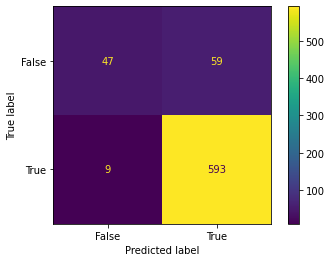

In [75]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

## Machine Learning Communication

### Rationale why modeling was implemented.
* While simpler forms of data analysis, such as descriptive statistics or basic data visualization, can provide initial insights, they may not be sufficient for complex problems or large datasets. Machine learning leverages advanced algorithms to uncover hidden patterns.

### Results.
> * Training accuracy: 96%
> * Testing accuracy: 90%

* The accuracy means that the model can predict with an accuracy of 90% whether a tweet is positive or negative.
* The current model is fit for prediction since it is generalizing well to new data even with high accuracy.

### Limitations of binary model.

* Not fit for multiclass datasets.

### testing logistic regression model here
* we take a sample sentence, preprocess it then pass it to the model to see the output.

In [76]:
# tweet
review = 'Awwww!! the google was sooo sweeet!! I loved it'
#review = 'i hate apple'

In [77]:
# lowecase
review = review.lower()
review

'awwww!! the google was sooo sweeet!! i loved it'

In [78]:
# removing punctuations
review = remove_punctuations(review)
review

'awwww the google was sooo sweeet i loved it'

In [79]:
# tokenizing the data
review = tokenize_text(review)
review

['awwww', 'the', 'google', 'was', 'sooo', 'sweeet', 'i', 'loved', 'it']

In [80]:
# removing stopwords
review = remove_stopwords(review)
review

'awwww google sooo sweeet loved'

In [81]:
review = tokenize_text(review)
review

['awwww', 'google', 'sooo', 'sweeet', 'loved']

In [82]:
# lemmatization
review = lem_words(review)
review

['awwww', 'google', 'sooo', 'sweeet', 'loved']

In [83]:
# joining to one sentence
review = ' '.join(review)

review

'awwww google sooo sweeet loved'

In [84]:
# putting to list
review = [review]
review

['awwww google sooo sweeet loved']

In [85]:
# vectorizing
review_x = bow2.transform(review)
review_x

<1x5871 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [86]:
test_predict = log_reg.predict(review_x)
test_predict

array([3])

### 6.2 multiclass classifier
* Here we work with the original dataset.
* We build a multi-class classifier.
* Multinomial, XGBoost and Random forest model will be tested.

#### MultinomialNB model

In [87]:
# importing library
from sklearn.naive_bayes import MultinomialNB

In [88]:
# target variable
y = data['emotion_code']

In [89]:
# splitting the data
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(x, y, test_size=0.2, random_state=42)

In [90]:
X_train_multi.shape, y_train_multi.shape

((7256, 9867), (7256,))

In [91]:
# instatiating the multi class model
multi_class = MultinomialNB()
# fitting the model
multi_class.fit(X_train_multi, y_train_multi)

MultinomialNB()

In [92]:
# predicting multi-class
y_pred_multi = multi_class.predict(X_test_multi)
y_train_pred_multi = multi_class.predict(X_train_multi)


In [93]:
# checking the accuracy

print('train',accuracy_score(y_train_multi, y_train_pred_multi))
print('test',accuracy_score(y_test_multi, y_pred_multi))

train 0.8036108048511577
test 0.6543550165380375


## Machine Learning Communication - MultiNomialmodel.

### Rationale why MultiNomial modeling was implemented.
* While simpler forms of modeling can do , they may not be able to work with multi-class datasets.

### Results.

* Accuracy on the training set: 80%
* Accuracy on the testing set: 66%

* The model is overfitting

### Limitations of multinomial model.
* The current model is not fit for prediction since it is not generalizing well to new data even with high accuracy. The model is overfitting.


#### XGBoost model

In [102]:

import xgboost as xgb

# Create an XGBoost classifier instance
xgb_classifier = xgb.XGBClassifier()

# Fit the model on the training data
xgb_classifier.fit(X_train_multi, y_train_multi)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [103]:
# Make predictions on the testing data
#predictions = xgb_classifier.predict(test_x)

y_pred_xgb =  xgb_classifier.predict(X_test_multi)
y_train_pred_xgb =  xgb_classifier.predict(X_train_multi)


In [104]:
# checking the accuracy

print('train',accuracy_score(y_train_multi, y_train_pred_xgb))
print('test',accuracy_score(y_test_multi, y_pred_xgb))

train 0.7848676957001103
test 0.685226019845645


## Machine Learning Communication XGBoost.

### Rationale why ensemble modeling will be implemented.
* While simpler forms of data analysis, such as descriptive statistics or basic data visualization, can provide initial insights, they are not sufficient for complex problems or large datasets such as this one. Ensemble models leverages advanced algorithms to uncover hidden patterns, make accurate predictions.

### Results.
* Accuracy on the training set: 78%

* Accuracy on the testing set: 68%

* The accuracy means that the model can predict with an accuracy of 78% whether a tweet falls within the specified labels.

### Limitations.

* The current model is not fit for prediction since it is overfitting.
* This we see from the difference between train and test accuracy.

## Resampling to handle the class imbalance issue.

We try to battle overfitting by handling imbalance issues in the classes, then modelling again.

### trying resampling with xgboost

In [105]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Creating an instance of the resampler
resampler = RandomOverSampler()  # or RandomUnderSampler()

# Perform resampling on the training data
resampled_features, resampled_labels = resampler.fit_resample(X_train_multi, y_train_multi)

# Create an XGBoost classifier instance
xgb_classifier = xgb.XGBClassifier()

# Fit the model on the resampled training data
xgb_classifier.fit(resampled_features, resampled_labels)

# Make predictions on the testing data
predictions = xgb_classifier.predict(X_test_multi)

# Evaluate the model
accuracy = accuracy_score(y_test_multi, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6097023153252481


## ML Communication

### Result
The resampled model has an accuracy of 61% which is not an improvement over prior models.

### limitations
The resampled model is not fit for modelling since its modelling accuracy is low.



# Final note on modelling
* Despite implementing resampling techniques to address class imbalance, the model's accuracy has not improved significantly. This suggests that other factors within the dataset may be limiting predictive performance.

* The binary logisitc regression model performs best and is fit to be deployed.
